# (1) 종속 패키지 설치하기

In [ ]:
# 종속 패키지(dependencies) 설치(pytorch, detectron2)
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

# 인스톨이 완료되면 Colab Runtime을 다시 시작해주세요. 

## 패키지 설치가 완료되면 Colab Runtime을 다시 시작해주세요.
> [런타임] - [런타임 다시 시작]



# (2) 유틸 Import

In [1]:
# 기본 설정
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
from collections import OrderedDict

# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# (3) github에서 TRAIN, VAL data들 가져오기

In [ ]:
!git clone https://github.com/parksunny94/GCL_Image.git

## (3.1) 이미지 Resize(1/4)

In [2]:
def resize_Image(img_dir):
  json_file = os.path.join(img_dir, "annotations.json")
  with open(json_file) as f:
    imgs_anns = json.load(f)
  
  for key, val in imgs_anns.items():
    filename = os.path.join(img_dir, key) # 이미지file 경로
    img = cv2.imread(filename) # 이미지 읽어오기
    img = cv2.resize(img,(0,0),fx=(1/4),fy=(1/4),interpolation=cv2.INTER_AREA) # 학습 이미지 Resize(1/4)
    cv2.imwrite(filename,img) # Resize한 이미지 저장

In [5]:
# TRAIN 폴더 내 이미지들 1/4로 Resize
resize_Image("GCL_Image/TRAIN")

In [3]:
# VAL 폴더 내 이미지들 1/4로 Resize
resize_Image("GCL_Image/VAL")

# (4) Detectron2에서 Data Set 정보를 로드하는 형식에 맞춰 함수를 작성하기

> 이미지 경로에서 Data set 뽑는 함수

In [6]:
# 이미지 경로에서 Data set 뽑는 함수
def get_PTN_dicts(img_dir):
    json_file = os.path.join(img_dir, "annotations.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    # 최종 결과물
    dataset_dicts = []
    
    idx = 0
    # 이미지들을 annotation한 json에서 이미지별로 하나씩 데이터 뽑아서 record에 저장(key : "이미지file.jpg", val : seg데이터)
    for key, val in imgs_anns.items():
        record = {} # 각 이미지별 정보 담을 dataset 포맷
        
        filename = os.path.join(img_dir, key) # 이미지file 경로
        img = cv2.imread(filename) # 이미지 읽어오기
        height, width = cv2.imread(filename).shape[:2] # 이미지file 경로로 cv2로 이미지 열어서 height, width 추출

        # 이미지 기본정보
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height / 4
        record["width"] = width / 4
      
        annos = val["instances"]
        objs = []

        # 이미지 기본정보 중 annotation_class별로 point들(x,y,x,y,x,y,...x,y순서) 뽑아서 obj에 담고 objs에 class별로 누적 후 record["annotations"]에 최종 저장
        for anno in annos:
            points = anno["points"]
            category_id = anno["classId"] - 1 # annotation.json이 1Base 기반
            px = []
            py = []

            # point들(x,y,x,y,x,y,...x,y순서) 뽑아서 px, py로 각각 list 생성
            for i in range(0,int(len(points)/2)):
              temp_x = points[i*2]
              temp_y = points[i*2+1]

              # [예외처리]point 위치값이 이미지 크기를 넘어간 경우 예외처리
              if(temp_x < 0):
                 temp_x = 0
              if(temp_y < 0):
                 temp_y = 0 
              if(temp_x >= width):
                temp_x = width-1
              if(temp_y >= height):
                temp_y = height-1

              px = px + [temp_x]
              py = py + [temp_y]

            # px, py list를 poly에 (x,y)형태로 묶어서 다시 list화
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            # obj dict에 (x,y)list를 토대로 Box만들고 list 등록
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
                "iscrowd": 0
            }
            objs.append(obj) # obj를 objs에 누적
        record["annotations"] = objs # objs를 record["annotations"]에 등록
        dataset_dicts.append(record) # record를 dataset에 누적
    return dataset_dicts

# (5) train, val 이미지들을 Metadata Set에 등록

In [7]:
for d in ["TRAIN", "VAL"]:
    DatasetCatalog.register("PTN_" + d, lambda d=d: get_PTN_dicts("GCL_Image/"+d))
    MetadataCatalog.get("PTN_" + d).set(thing_classes=["ACTIVE","PTN1","PTN2","PTN3"])
PTN_metadata = MetadataCatalog.get("PTN_TRAIN")

## (선택) 데이터가 제대로 로드되었는지 확인

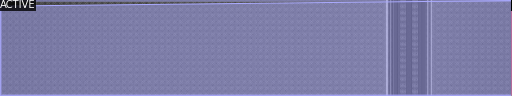

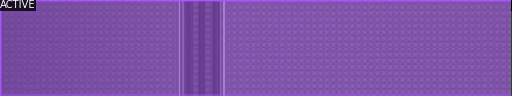

In [8]:
# TRAIN 폴더에서 Metadata Set 뽑기
dataset_dicts = get_PTN_dicts("GCL_Image/TRAIN")
random_count = 2
# Metadata Set 중에서 3개 랜덤하게 뽑아서 annotation한 영역 그리기
for d in random.sample(dataset_dicts, random_count):
    img = cv2.imread(d["file_name"])
    #img = cv2.resize(img,(0,0),fx=(1/4),fy=(1/4),interpolation=cv2.INTER_AREA) # 결과 이미지 Resize -> 안하면 런타임 죽을 수도 있음
    visualizer = Visualizer(img[:, :, ::-1], metadata=PTN_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# (6) 학습하기

## (6.1) Instance Segmentation 학습

자 이제 학습을 진행할 단계입니다. COCO 데이터셋으로 학습된 R50-FPN Mask R-CNN 모델을 불러와서 풍선 데이터셋으로 fine-tune해 봅시다.
Colab의 K80 GPU를 기준으로, 300 iterations 학습시키는데 대략 6분정도의 시간이 소요됩니다(P100 GPU의 경우 2분 가량 소요됩니다).

In [ ]:
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("PTN_TRAIN",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100   # 300 iterations 정도면 충분합니다. 더 오랜 시간도 시도해보세요.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8   # 풍선 데이터셋과 같이 작은 데이터셋에서는 128이면 적당합니다.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 클래스는 "풍선" 클래스 하나 뿐입니다.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# 결과 모델은 output/model_final.pth로 남음

### (선택) 학습 커브 확인

In [ ]:
# tensorboard를 사용해서 학습 커브를 살펴봅니다.
%load_ext tensorboard
%tensorboard --logdir output

## (6.3) 학습한 모델 실행 및 평가하기
자 이제 풍선 데이터셋의 검증(validation) 데이터셋으로 테스트를 해볼 차례입니다. 

우선, 방금 전 학습한 모델을 불러와서 `predictor`를 생성합니다.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PTN_VAL", )
predictor = DefaultPredictor(cfg)

### (6.4) 샘플 Resize(1/4) 및 추출

> 학습한 predictor에 Data Set기반으로 Segmentation 진행

In [ ]:
# 학습한 predictor에 Data Set기반으로 Segmentation 진행
def sampleTest(d):
  # Data Set에서 이미지 정보 추출
  img = cv2.imread(d["file_name"])
  #img = cv2.resize(img,(0,0),fx=(1/4),fy=(1/4),interpolation=cv2.INTER_AREA) # 결과 이미지 Resize -> 안하면 런타임 죽을 수도 있음

  # 학습한 predictor에 이미지 넣어서 검증
  output = predictor(img) # 랜덤하게 뽑은 이미지를 predictor로 검증
  outputs.append(output) # 검증한 결과데이터(output) 누적하기(outputs)

  # 이미지 그리기 준비
  v = Visualizer(img[:, :, ::-1],
                  metadata=PTN_metadata, 
                  scale=0.8, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
  )
  v = v.draw_instance_predictions(output["instances"].to("cpu"))

  # 이미지 그리기
  cv2_imshow(v.get_image()[:, :, ::-1])

  # 검증결과 데이터 리턴
  return outputs

In [ ]:
# VAL 폴더에서 Metadata Set 뽑기
dataset_dicts = get_PTN_dicts("GCL_Image/VAL")
# Metadata Set 중에서 3개 랜덤하게 뽑아서 Segmentation한 영역 그리기(outputs)
outputs = []
random_count = 2
for d in random.sample(dataset_dicts, random_count):
    outputs = sampleTest(d)


# (7) 테두리 영역 추출하기

## (7.1) seg 영역 → Binary → 테두리 영역 추출

In [ ]:
# 테두리 영역진행한 이미지들[이미지번호][seg영역번호]
outline_arrays_arrays = []

# 각 이미지 별(n)
for n in range(len(outputs)):
  # 한 이미지 내 테두리 영역들
  outline_arrays = []
  output = outputs[n]['instances'] # 랜덤하게 뽑은 이미지들(outputs[n])에서 이미지 하나씩(output)
  mask_array = output.to("cpu").pred_masks.numpy() # 이미지(output) 내 seg 영역들 추출(mask_array)

  height = (output.image_size)[0] # 이미지 높이
  width = (output.image_size)[1] # 이미지 너비

  # 한 이미지의 seg영역 별(m)
  for m in range(len(mask_array)):
    bin_array = np.zeros(shape=(height,width)) # Binaray 용(mask_array)
    outline_array = np.zeros(shape=(height,width)) # 테두리 용(outline_array)

    # seg영역(mask_array) → Binary영역(bin_array) 치환
    for i in range(height):
      for j in range(width):
        if mask_array[m][i][j]:
          bin_array[i][j] = 255
    
    # Binary영역(bin_array) → 테두리 추출(outline_array)
    for p in range(height): 
      for q in range(width):
        if bin_array[p][q] == 255:
          # [예외처리] 이미지 위아래 끝단일 경우
          if p == 0 or p == (height-1):
            outline_array[p][q] = 255
          # [예외처리] 이미지 좌우 끝단일 경우
          elif q == 0 or q == (width-1):
            outline_array[p][q] = 255
          # 테두리일 경우
          elif bin_array[p-1][q] == 0 or bin_array[p][q-1] == 0 or bin_array[p+1][q] == 0 or bin_array[p][q+1] == 0:
            outline_array[p][q] = 255
          # 테두리가 아닐 경우
          else:
            outline_array[p][q] = 0
            
    cv2_imshow(outline_array) # 그려보기
    outline_arrays.append(outline_array) # 한 이미지 내 테두리 이미지들(outline_array) 누적하기(outline_arrays)
  
  outline_arrays_arrays.append(outline_arrays) # 이미지들(outline_arrays) 누적하기(outline_arrays_arrays)
    

## (7.2) 테두리 중 직선부 중복 빼기

In [ ]:
deDupli_array = [] # 중복 뺀 결과 이미지들

for i in range(len(outline_arrays_arrays)):
  deDupli = [] # 중복 뺀 한 이미지
  for j in range(len(outline_arrays_arrays[i])):
    outline_arrays = outline_arrays_arrays[i][j] # 테두리 영역
    
    height = len(outline_arrays)
    width = len(outline_arrays[0])

    output_temp1 = np.zeros(shape=(height,width)) # 가로방향 중복 제거용
    output_temp2 = np.zeros(shape=(height,width)) # 세로방향 중복 제거용
    output = np.zeros(shape=(height,width)) # 가로/세로방향 중복 제거 후 Merge 결과물
    
    # [예외처리] 이미지 상부 끝단일 경우
    for n in range(1, width):
      if outline_arrays[0][n] == outline_arrays[0][n-1]:
        outline_arrays[0][n] = 0
    # [예외처리] 이미지 하부 끝단일 경우
    for n in range(1,width):
      if outline_arrays[height-1][n] == outline_arrays[height-1][n-1]:
        outline_arrays[height-1][n] = 0
    # [예외처리] 이미지 좌측 끝단일 경우
    for n in range(1, height):
      if outline_arrays[n][0] == outline_arrays[n-1][0]:
        outline_arrays[n][0] = 0
    # [예외처리] 이미지 우측 단일 경우
    for n in range(1, height):
      if outline_arrays[n][width-1] == outline_arrays[n][width-1]:
        outline_arrays[n][width-1] = 0
    
    # 가로/세로방향 각각 중복 제거하기
    for n in range(1, height-1):
      for m in range(1, width-1):
        if outline_arrays[n][m] == 255:
          if outline_arrays[n][m] != outline_arrays[n][m-1]:
            output_temp1[n][m] = 255
          if outline_arrays[n][m] != outline_arrays[n][m+1]:
            output_temp1[n][m] = 255
          if outline_arrays[n][m] != outline_arrays[n-1][m]:
            output_temp2[n][m] = 255
          if outline_arrays[n][m] != outline_arrays[n+1][m]:
            output_temp2[n][m] = 255
    
    # 가로/세로방향 각각 중복 제거 후 Merge하기
    for n in range(1, height-1):
      for m in range(1, width-1):
        if output_temp1[n][m] == 255 and output_temp2[n][m] == 255:
          output[n][m] = 255

    cv2_imshow(output) # 그려보기
    deDupli.append(output) # 한 이미지 내 테두리 영역(output)
  deDupli_array.append(deDupli) # 이미지들

# (8) json으로 저장



> json 변수에 저장



In [ ]:
Block = 0 # json에서 Block번호
Block_Area = 0 # json에서 한 Block 내 테두리 영역별 번호
output_json = OrderedDict() # json 변수

for i in range(len(deDupli_array)):
  deDupli = deDupli_array[i]

  for j in range(len(deDupli)):
    array = deDupli[j]
    height = len(array)
    width = len(array[0])

    points = {}
    cnt_x = 1
    cnt_y = 1

    for n in range(height):
      for m in range(width):
        if array[n][m] == 255:
          points["Point_x_"+str(cnt_x)] = m
          points["Point_y_"+str(cnt_y)] = n
          cnt_x += 1
          cnt_y += 1
    
    output_json['Blcok#' + str(Block) + '_' + 'Area#' + str(Block_Area)] = points
    Block_Area += 1
  Block += 1

In [ ]:
print(json.dumps(output_json,indent='\t'))

> json 파일에 저장

In [ ]:
with open("test.json", 'w') as file:
    json.dump(output_json,file,indent='\t')